# Second model 
- For now, use **RandomForestClassifier** because it's fairly quick, and has comparable performance according to **2018_09_12_compare_algorithms.ipynb** and therefore is good for testing new feature engineering, etc

# TODO - 
- PCA or other dimensionality reduction on all the housing material features

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.externals import joblib

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.pipeline import kfold, f1_scorer, FeatureExtractor, FeatureEngineer, LazyProcessing
from lib.visualization import plot_confusion_matrix, plot_learning_curve
from lib.preprocessing import preprocess
import lib.preprocessing as prep

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Important: 
According to the competition (https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), **ONLY heads of household are used in the scoring**. So we should only fit and evaluate our model on these observations (though in preprocessing we may use all individuals in household-level feature engineering). 
We do, however, need to keep all test data observations for submission. (here is a kernel showing some exploration of discrepancy of labels within households and some individuals without a head of household, but should be irrelevant if we only train on heads https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough)

In [6]:
test_features = ['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled'] + [
    'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability'] + [
    'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo', 'abastaguano', 'noelec', 'sanitario1'] + [
    'asset_index', 'v18q', 'v18q1', 'refrig', 'computer', 'television'] + [
    'tamviv', 'hogar_nin', 'overcrowding'] + [
    'calc_dependency', 'calc_dependency_bin'] + [
    'phones_pc', 'tablets_pc', 'rooms_pc', 'rent_pc'] + [
    'v2a1', 'v2a1_missing']

In [7]:
#NOTE - preprocessing has not yet been intelligently integrated into the pipeline
# It is possible to use the LazyProcessing transformer, but it is clunky and slow, 
# so for now I'll do manual preprocessing as a script
X_train = preprocess(train).drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
X_test = preprocess(test)
y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household
# X_train[test_features].head()

# X_train = train.drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
# X_test = test.copy()
# y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household

In [8]:
train = prep.preprocess(train)

## Build a feature union of some of the data prep to gate off some feature engineering

In [13]:
feature_extraction = FeatureUnion(transformer_list=[
    ('extract_rent', FeatureEngineer(prep.feature_engineer_rent)),
    ('extract_educ', FeatureEngineer(prep.feature_engineer_education)),
    ('extract_demog', FeatureEngineer(prep.feature_engineer_demographics)),
    ('extract_houseq', FeatureEngineer(prep.feature_engineer_house_rankings)),
    ('extract_housec', FeatureEngineer(prep.feature_engineer_house_characteristics)),
    ('extract_assets', FeatureEngineer(prep.feature_engineer_assets))
])

In [14]:
feature_extraction.fit_transform(train)

array([[1.90e+05, 3.00e+00, 1.00e+06, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.35e+05, 3.00e+00, 1.35e+05, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 2.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [8.00e+04, 3.00e+00, 3.20e+05, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [8.00e+04, 3.00e+00, 3.20e+05, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [8.00e+04, 3.00e+00, 3.20e+05, ..., 0.00e+00, 0.00e+00, 1.00e+00]])

In [15]:
full_pipeline = Pipeline(steps=[
                        ('features', feature_extraction),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])
                        # ('svc', SVC(kernel='rbf', random_state=1))])

In [16]:
# full_pipeline.get_params()

In [17]:
cross_val_score(full_pipeline, train, train['Target'], cv =kfold, scoring=f1_scorer, n_jobs=-1)

array([0.41515915, 0.35438838, 0.3618032 , 0.35687075, 0.36117005])

In [26]:
LEVELS = ['low']
DEPTHS = [10,20,30,40]
param_grid = dict(features__extract_educ__level=LEVELS,
                 features__extract_rent__level=LEVELS,
                 features__extract_demog__level=LEVELS,
                 features__extract_houseq__level=LEVELS,
                 features__extract_housec__level=LEVELS,
                 features__extract_assets__level=LEVELS,
                 random_forest__max_depth=DEPTHS,
                 # svc__gamma=[0.01, 0.1,1,10],
                 # svc__C=[0.001,0.01,0.1,1,10,100,1000]
                 )

In [27]:
%%time

grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=1)
grid.fit(train, train['Target'])

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 30}
Wall time: 48.3 s


In [28]:
cross_val_score(grid.best_estimator_, train, train['Target'], cv =kfold, scoring=f1_scorer, n_jobs=-1)

array([0.41515915, 0.35438838, 0.36362394, 0.36000659, 0.36117005])

In [42]:
cross_val_score(grid.best_estimator_, train, train['Target'], cv =kfold, scoring=f1_scorer, n_jobs=-1)

array([0.33535615, 0.35673683, 0.35920452, 0.33451028, 0.33248523])

In [31]:
np.mean([0.3889476 , 0.37780798, 0.45224717, 0.35253181, 0.38804336])

0.391915584

In [36]:
np.mean([0.35045197, 0.32453732, 0.43046873, 0.37497069, 0.32954446])

0.36199463400000004

In [65]:
feature_extraction.fit_transform(train)

array([[1.90e+05, 1.00e+01, 1.00e+01, 0.00e+00, 0.00e+00],
       [1.35e+05, 1.20e+01, 1.20e+01, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.10e+01, 1.10e+01, 0.00e+00, 0.00e+00],
       ...,
       [8.00e+04, 8.25e+00, 5.00e+00, 0.00e+00, 0.00e+00],
       [8.00e+04, 8.25e+00, 1.10e+01, 0.00e+00, 0.00e+00],
       [8.00e+04, 8.25e+00, 8.00e+00, 0.00e+00, 0.00e+00]])

In [9]:
full_pipeline = Pipeline(steps=[
                        # ('feature_extraction', feature_extraction),
                        ('feature_selection', FeatureExtractor(['meaneduc','tamviv', 'v2a1'])),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [11]:
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=1)
grid.fit(train, train['Target'])

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

TypeError: All intermediate steps should be transformers and implement fit and transform. 'True' (type <class 'bool'>) doesn't

In [51]:
from lib.pipeline import FeatureEngineer

{'random_forest__max_depth': 25}
Cross Validation F1 Score = 0.3522 with std = 0.0233
Wall time: 13.3 s


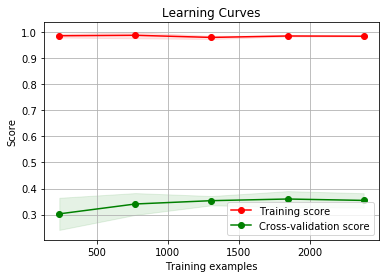

In [39]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

# Goal - compare cv scores of model with and without feature selection
For now, we will do some crude tuning using `max_depth`

In [12]:
param_grid = dict(random_forest__max_depth=[10,15,20,25,30])

## Manual test_features 

In [13]:
full_pipeline = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [25]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'random_forest__max_depth': 20}
Wall time: 4.15 s


Cross Validation F1 Score = 0.359 with std = 0.0234
Wall time: 8.63 s


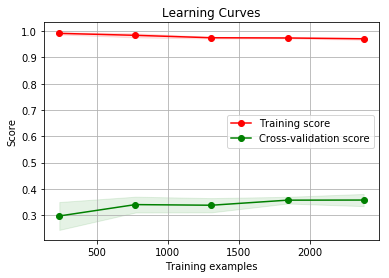

In [26]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

## Automated feature selection

In [106]:
param_grid_2 = dict(
                    # feature_selection__threshold=[0.005, 0.01,],
                    random_forest__max_depth=[15,20,25,30])

In [127]:
full_pipeline = Pipeline(steps=[
                        # ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(RandomForestClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [128]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid_2, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'random_forest__max_depth': 30}
Wall time: 10.5 s


Cross Validation F1 Score = 0.3505 with std = 0.0357
Wall time: 9.97 s


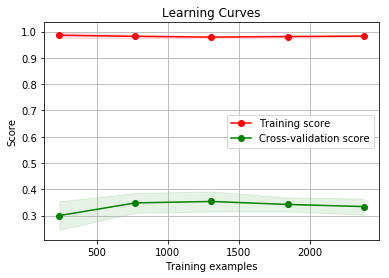

In [118]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

## Use PCA instead of feature selection

In [131]:
param_grid_3 = dict(
                    pca__n_components=[10, 20, 30],
                    random_forest__max_depth=[15,20,25,30])

In [132]:
full_pipeline = Pipeline(steps=[
                        # ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(RandomForestClassifier())),
                        ('pca', PCA(n_components = 20)),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [133]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid_3, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'pca__n_components': 10, 'random_forest__max_depth': 30}
Wall time: 10.7 s


Cross Validation F1 Score = 0.3395 with std = 0.0139
Wall time: 12.4 s


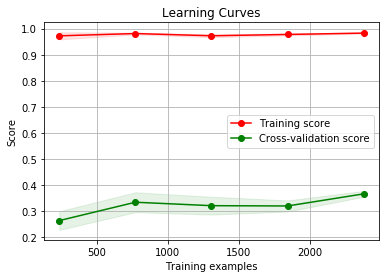

In [134]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

## Use all features

In [14]:
full_pipeline = Pipeline(steps=[
                        # ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [15]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'random_forest__max_depth': 15}
Wall time: 5.98 s


Cross Validation F1 Score = 0.3649 with std = 0.0398
Wall time: 9.5 s


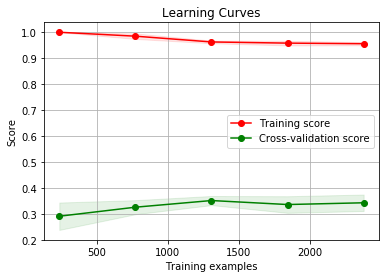

In [16]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [17]:
estimator = model.steps[-1][1]

# WARNING - need to fix for automated feature selection, as column names/orders are not preserved
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': estimator.feature_importances_})
feature_importances.sort_values('importance', ascending=False)[:20]

# estimator.feature_importances_

ValueError: arrays must all be same length

In [8]:
from lightgbm import LGBMClassifier

In [9]:
clf = LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=1, silent=True, metric='None', 
                             n_jobs=-1, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

In [10]:
full_pipeline = Pipeline(steps=[
                        # ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', clf)])

In [11]:
param_grid_2 = dict(
                    # feature_selection__threshold=[0.005, 0.01,],
                    imputer__strategy=['median', 'mean'])

In [12]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid_2, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'imputer__strategy': 'median'}
Wall time: 7min 52s


Cross Validation F1 Score = 0.3107 with std = 0.0581


JoblibLightGBMError: JoblibLightGBMError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_code(code=<code object <module> at 0x000001E0CE8FDC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001E0CE8FDC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1429                         logger.warning('Executing %s took %.3f seconds',
   1430                                        _format_handle(handle), dt)
   1431                 finally:
   1432                     self._current_handle = None
   1433             else:
-> 1434                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...01E0E34C30D0>))>>
   1435         handle = None  # Needed to break cycles when an exception occurs.
   1436 
   1437     def _set_coroutine_wrapper(self, enabled):
   1438         try:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...01E0E34C30D0>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x000001E0E34C30D0>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x000001E0E34C30D0>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x000001E0E34C30D0>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 18, 3, 56, 23, 980520, tzinfo=tzutc()), 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'session': '935225560e62425cbad3c9a2025a60f9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'935225560e62425cbad3c9a2025a60f9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 18, 3, 56, 23, 980520, tzinfo=tzutc()), 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'session': '935225560e62425cbad3c9a2025a60f9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'935225560e62425cbad3c9a2025a60f9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 18, 3, 56, 23, 980520, tzinfo=tzutc()), 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'session': '935225560e62425cbad3c9a2025a60f9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'cf7cbb424c4041f0a6c7acca1194306a', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\nmodel = grid.best_estimator_\nmodel.fit(X_...', X_train, y_train, cv=kfold, scoring=f1_scorer)", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-13-92c64fa16c8a>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1e0e32cf358, executio...rue silent=False shell_futures=True> result=None>)
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])
   2906                 code = compiler(mod, cell_name, "single")
-> 2907                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001E0E32ADED0, file "<ipython-input-13-92c64fa16c8a>", line 1>
        result = <ExecutionResult object at 1e0e32cf358, executio...rue silent=False shell_futures=True> result=None>
   2908                     return True
   2909 
   2910             # Flush softspace
   2911             if softspace(sys.stdout, 0):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001E0E32ADED0, file "<ipython-input-13-92c64fa16c8a>", line 1>, result=<ExecutionResult object at 1e0e32cf358, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001E0E32ADED0, file "<ipython-input-13-92c64fa16c8a>", line 1>
        self.user_global_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FeatureExtractor': <class 'lib.pipeline.FeatureExtractor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'X_train.max()', "get_ipython().run_line_magic('load_ext', 'autore...)\nget_ipython().run_line_magic('autoreload', '2')", "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", 'from sklearn.preprocessing import Imputer\nfrom s...val_predict\n\nfrom sklearn.externals import joblib', '# Add library to path \nmodule_path = os.path.abs...ng_curve\nfrom lib.preprocessing import preprocess', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", '#NOTE - preprocessing has not yet been intellige...try subsetting to ONLY train on head of household', 'from lightgbm import LGBMClassifier', 'clf = LGBMClassifier(max_depth=-1, learning_rate..._samples = 95, num_leaves = 14, subsample = 0.96)', "full_pipeline = Pipeline(steps=[\n               ...\n                        ('random_forest', clf)])", "param_grid_2 = dict(\n                    # featu...            imputer__strategy=['median', 'mean'])", 'get_ipython().run_cell_magic(\'time\', \'\', "grid =..._[\'mean_test_score\'])\\nprint(grid.best_params_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "model ... X_train, y_train, cv=kfold, scoring=f1_scorer)")'], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'LazyProcessing': <class 'lib.pipeline.LazyProcessing'>, 'Out': {}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        self.user_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FeatureExtractor': <class 'lib.pipeline.FeatureExtractor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'X_train.max()', "get_ipython().run_line_magic('load_ext', 'autore...)\nget_ipython().run_line_magic('autoreload', '2')", "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", 'from sklearn.preprocessing import Imputer\nfrom s...val_predict\n\nfrom sklearn.externals import joblib', '# Add library to path \nmodule_path = os.path.abs...ng_curve\nfrom lib.preprocessing import preprocess', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", '#NOTE - preprocessing has not yet been intellige...try subsetting to ONLY train on head of household', 'from lightgbm import LGBMClassifier', 'clf = LGBMClassifier(max_depth=-1, learning_rate..._samples = 95, num_leaves = 14, subsample = 0.96)', "full_pipeline = Pipeline(steps=[\n               ...\n                        ('random_forest', clf)])", "param_grid_2 = dict(\n                    # featu...            imputer__strategy=['median', 'mean'])", 'get_ipython().run_cell_magic(\'time\', \'\', "grid =..._[\'mean_test_score\'])\\nprint(grid.best_params_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "model ... X_train, y_train, cv=kfold, scoring=f1_scorer)")'], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'LazyProcessing': <class 'lib.pipeline.LazyProcessing'>, 'Out': {}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<ipython-input-13-92c64fa16c8a> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', "model = grid.best_estimator_\nmodel.fit(X_train, y_train)\n\ncv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)\nprint(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')\n\nplot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)")

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell="model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)")
   2162             # This will need to be updated if the internal calling logic gets
   2163             # refactored, or else we'll be expanding the wrong variables.
   2164             stack_depth = 2
   2165             magic_arg_s = self.var_expand(line, stack_depth)
   2166             with self.builtin_trap:
-> 2167                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = "model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)"
   2168             return result
   2169 
   2170     def find_line_magic(self, magic_name):
   2171         """Find and return a line magic by name.

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<decorator-gen-63> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", local_ns=None)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', "model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', "model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", local_ns=None)
   1232                 return
   1233             end = clock2()
   1234         else:
   1235             st = clock2()
   1236             try:
-> 1237                 exec(code, glob, local_ns)
        code = <code object <module> at 0x000001E0E32A5D20, file "<timed exec>", line 1>
        glob = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'FeatureExtractor': <class 'lib.pipeline.FeatureExtractor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'X_train.max()', "get_ipython().run_line_magic('load_ext', 'autore...)\nget_ipython().run_line_magic('autoreload', '2')", "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", 'from sklearn.preprocessing import Imputer\nfrom s...val_predict\n\nfrom sklearn.externals import joblib', '# Add library to path \nmodule_path = os.path.abs...ng_curve\nfrom lib.preprocessing import preprocess', "train = pd.read_csv('../input/train.csv')\ntest = pd.read_csv('../input/test.csv')", '#NOTE - preprocessing has not yet been intellige...try subsetting to ONLY train on head of household', 'from lightgbm import LGBMClassifier', 'clf = LGBMClassifier(max_depth=-1, learning_rate..._samples = 95, num_leaves = 14, subsample = 0.96)', "full_pipeline = Pipeline(steps=[\n               ...\n                        ('random_forest', clf)])", "param_grid_2 = dict(\n                    # featu...            imputer__strategy=['median', 'mean'])", 'get_ipython().run_cell_magic(\'time\', \'\', "grid =..._[\'mean_test_score\'])\\nprint(grid.best_params_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "model ... X_train, y_train, cv=kfold, scoring=f1_scorer)")'], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'LazyProcessing': <class 'lib.pipeline.LazyProcessing'>, 'Out': {}, 'PCA': <class 'sklearn.decomposition.pca.PCA'>, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        local_ns = None
   1238             except:
   1239                 self.shell.showtraceback()
   1240                 return
   1241             end = clock2()

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<timed exec> in <module>()

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\lib\visualization.py in plot_learning_curve(estimator=Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]), title='Learning Curves', X=          v2a1  hacdor  rooms  hacapo  v14a  ref...45          1.099681  

[2973 rows x 242 columns], y=0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64, ylim=None, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False), scoring=make_scorer(f1_score, average=macro), n_jobs=-1, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))
     33     if ylim is not None:
     34         plt.ylim(*ylim)
     35     plt.xlabel("Training examples")
     36     plt.ylabel("Score")
     37     train_sizes, train_scores, test_scores = learning_curve(
---> 38         estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
        estimator = Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))])
        X =           v2a1  hacdor  rooms  hacapo  v14a  ref...45          1.099681  

[2973 rows x 242 columns]
        y = 0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64
        cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
        scoring = make_scorer(f1_score, average=macro)
        n_jobs = -1
        train_sizes = array([0.1  , 0.325, 0.55 , 0.775, 1.   ])
     39     train_scores_mean = np.mean(train_scores, axis=1)
     40     train_scores_std = np.std(train_scores, axis=1)
     41     test_scores_mean = np.mean(test_scores, axis=1)
     42     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py in learning_curve(estimator=Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]), X=          v2a1  hacdor  rooms  hacapo  v14a  ref...45          1.099681  

[2973 rows x 242 columns], y=0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64, groups=None, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False), scoring=make_scorer(f1_score, average=macro), exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0, shuffle=False, random_state=None)
   1123                 train_test_proportions.append((train[:n_train_samples], test))
   1124 
   1125         out = parallel(delayed(_fit_and_score)(
   1126             clone(estimator), X, y, scorer, train, test,
   1127             verbose, parameters=None, fit_params=None, return_train_score=True)
-> 1128             for train, test in train_test_proportions)
        train = array([   0,    1,    2, ..., 2521, 2534, 2535])
        test = array([2270, 2271, 2272, 2273, 2275, 2277, 2278,... 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972])
        train_test_proportions = [(array([506, 507, 508, 509, 510, 511, 512, 513, 5..., 792, 793, 794, 795, 796,
       798, 799, 800]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097])), (array([ 506,  507,  508,  509,  510,  511,  512,...1361, 1362, 1363, 1364, 1365,
       1366, 1367]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097])), (array([ 506,  507,  508, ..., 1900, 1901, 1902]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097])), (array([ 506,  507,  508, ..., 2435, 2436, 2437]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097])), (array([ 506,  507,  508, ..., 2970, 2971, 2972]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 229, 230, 231, 232, 233,
       234, 235, 236]), array([ 506,  507,  508,  509,  510,  511,  512,...1698, 1719, 1723, 1729, 1730,
       1732, 1735])), (array([   0,    1,    2,    3,    4,    5,    6,...1297, 1299, 1300, 1301, 1302,
       1303, 1304]), array([ 506,  507,  508,  509,  510,  511,  512,...1698, 1719, 1723, 1729, 1730,
       1732, 1735])), (array([   0,    1,    2, ..., 1900, 1901, 1902]), array([ 506,  507,  508,  509,  510,  511,  512,...1698, 1719, 1723, 1729, 1730,
       1732, 1735])), (array([   0,    1,    2, ..., 2435, 2436, 2437]), array([ 506,  507,  508,  509,  510,  511,  512,...1698, 1719, 1723, 1729, 1730,
       1732, 1735])), (array([   0,    1,    2, ..., 2970, 2971, 2972]), array([ 506,  507,  508,  509,  510,  511,  512,...1698, 1719, 1723, 1729, 1730,
       1732, 1735])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 229, 230, 231, 232, 233,
       234, 235, 236]), array([1033, 1034, 1036, 1037, 1038, 1039, 1041,... 2108, 2109, 2112, 2131, 2133, 2139, 2152, 2153])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 764, 765, 766,
       767, 768, 769, 770, 771]), array([1033, 1034, 1036, 1037, 1038, 1039, 1041,... 2108, 2109, 2112, 2131, 2133, 2139, 2152, 2153])), (array([   0,    1,    2, ..., 1776, 1777, 1778]), array([1033, 1034, 1036, 1037, 1038, 1039, 1041,... 2108, 2109, 2112, 2131, 2133, 2139, 2152, 2153])), (array([   0,    1,    2, ..., 2433, 2434, 2435]), array([1033, 1034, 1036, 1037, 1038, 1039, 1041,... 2108, 2109, 2112, 2131, 2133, 2139, 2152, 2153])), (array([   0,    1,    2, ..., 2968, 2969, 2970]), array([1033, 1034, 1036, 1037, 1038, 1039, 1041,... 2108, 2109, 2112, 2131, 2133, 2139, 2152, 2153])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 229, 230, 231, 232, 233,
       234, 235, 236]), array([1594, 1595, 1597, 1598, 1599, 1601, 1602,... 2510, 2512, 2516, 2517, 2518, 2521, 2534, 2535])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 764, 765, 766,
       767, 768, 769, 770, 771]), array([1594, 1595, 1597, 1598, 1599, 1601, 1602,... 2510, 2512, 2516, 2517, 2518, 2521, 2534, 2535])), (array([   0,    1,    2, ..., 1304, 1305, 1306]), array([1594, 1595, 1597, 1598, 1599, 1601, 1602,... 2510, 2512, 2516, 2517, 2518, 2521, 2534, 2535])), (array([   0,    1,    2, ..., 2355, 2356, 2360]), array([1594, 1595, 1597, 1598, 1599, 1601, 1602,... 2510, 2512, 2516, 2517, 2518, 2521, 2534, 2535])), (array([   0,    1,    2, ..., 2968, 2969, 2970]), array([1594, 1595, 1597, 1598, 1599, 1601, 1602,... 2510, 2512, 2516, 2517, 2518, 2521, 2534, 2535])), ...]
   1129         out = np.array(out)
   1130         n_cv_folds = out.shape[0] // n_unique_ticks
   1131         out = out.reshape(n_cv_folds, n_unique_ticks, 2)
   1132 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
LightGBMError                                      Mon Sep 17 21:08:26 2018
PID: 6608Python 3.6.6: c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\python.exe
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]),           v2a1  hacdor  rooms  hacapo        ...... 145          1.099681

[2973 rows x 242 columns], 0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64, make_scorer(f1_score, average=macro), array([506, 507, 508, 509, 510, 511, 512, 513, 5..., 792, 793, 794, 795, 796,
       798, 799, 800]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]),           v2a1  hacdor  rooms  hacapo        ...... 145          1.099681

[2973 rows x 242 columns], 0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64, make_scorer(f1_score, average=macro), array([506, 507, 508, 509, 510, 511, 512, 513, 5..., 792, 793, 794, 795, 796,
       798, 799, 800]), array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]), X=          v2a1  hacdor  rooms  hacapo        ...... 145          1.099681

[2973 rows x 242 columns], y=0       4
1       4
2       4
5       4
8       ...552    2
Name: Target, Length: 2973, dtype: int64, scorer=make_scorer(f1_score, average=macro), train=array([506, 507, 508, 509, 510, 511, 512, 513, 5..., 792, 793, 794, 795, 796,
       798, 799, 800]), test=array([   0,    1,    2,    3,    4,    5,    6,... 952,  964,  995,  998, 1082,
       1088, 1097]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...  subsample_for_bin=200000, subsample_freq=0))])>
        X_train =           v2a1  hacdor  rooms  hacapo        ......   88          1.740258

[237 rows x 242 columns]
        y_train = 1567    4
1571    4
1574    4
1577    4
1578    ...2488    4
Name: Target, Length: 237, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('imputer', Im...   subsample_for_bin=200000, subsample_freq=0))]), X=          v2a1  hacdor  rooms  hacapo        ......   88          1.740258

[237 rows x 242 columns], y=1567    4
1571    4
1574    4
1577    4
1578    ...2488    4
Name: Target, Length: 237, dtype: int64, **fit_params={})
    245         self : Pipeline
    246             This estimator
    247         """
    248         Xt, fit_params = self._fit(X, y, **fit_params)
    249         if self._final_estimator is not None:
--> 250             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method LGBMClassifier.fit of LGBMClassifi...     subsample_for_bin=200000, subsample_freq=0)>
        Xt = array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]])
        y = 1567    4
1571    4
1574    4
1577    4
1578    ...2488    4
Name: Target, Length: 237, dtype: int64
        fit_params = {}
    251         return self
    252 
    253     def fit_transform(self, X, y=None, **fit_params):
    254         """Fit the model and transform with the final estimator

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py in fit(self=LGBMClassifier(boosting_type='gbdt', class_weigh...      subsample_for_bin=200000, subsample_freq=0), X=array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]]), y=1567    4
1571    4
1574    4
1577    4
1578    ...2488    4
Name: Target, Length: 237, dtype: int64, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric='binary_logloss', early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None)
    690                                         eval_init_score=eval_init_score,
    691                                         eval_metric=eval_metric,
    692                                         early_stopping_rounds=early_stopping_rounds,
    693                                         verbose=verbose, feature_name=feature_name,
    694                                         categorical_feature=categorical_feature,
--> 695                                         callbacks=callbacks)
        callbacks = None
    696         return self
    697 
    698     _base_doc = LGBMModel.fit.__doc__
    699     fit.__doc__ = (_base_doc[:_base_doc.find('eval_metric :')]

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py in fit(self=LGBMClassifier(boosting_type='gbdt', class_weigh...      subsample_for_bin=200000, subsample_freq=0), X=array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]]), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), sample_weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1... 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), init_score=None, group=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_group=None, eval_metric='binary_logloss', early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None)
    469                               self.n_estimators, valid_sets=valid_sets, valid_names=eval_names,
    470                               early_stopping_rounds=early_stopping_rounds,
    471                               evals_result=evals_result, fobj=self._fobj, feval=feval,
    472                               verbose_eval=verbose, feature_name=feature_name,
    473                               categorical_feature=categorical_feature,
--> 474                               callbacks=callbacks)
        callbacks = None
    475 
    476         if evals_result:
    477             self._evals_result = evals_result
    478 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py in train(params={'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'min_child_samples': 95, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'nthread': -1, 'num_leaves': 14, ...}, train_set=<lightgbm.basic.Dataset object>, num_boost_round=5000, valid_sets=[], valid_names=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, evals_result={}, verbose_eval=True, learning_rates=None, keep_training_booster=False, callbacks={<function record_evaluation.<locals>.callback>, <function print_evaluation.<locals>.callback>})
    178     callbacks_before_iter = sorted(callbacks_before_iter, key=attrgetter('order'))
    179     callbacks_after_iter = sorted(callbacks_after_iter, key=attrgetter('order'))
    180 
    181     # construct booster
    182     try:
--> 183         booster = Booster(params=params, train_set=train_set)
        booster = undefined
        params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'min_child_samples': 95, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'nthread': -1, 'num_leaves': 14, ...}
        train_set = <lightgbm.basic.Dataset object>
    184         if is_valid_contain_train:
    185             booster.set_train_data_name(train_data_name)
    186         for valid_set, name_valid_set in zip(reduced_valid_sets, name_valid_sets):
    187             booster.add_valid(valid_set, name_valid_set)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py in __init__(self=<lightgbm.basic.Booster object>, params={'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'min_child_samples': 95, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'nthread': -1, 'num_leaves': 14, ...}, train_set=<lightgbm.basic.Dataset object>, model_file=None, silent=False)
   1302                 raise TypeError('Training data should be Dataset instance, met {}'.format(type(train_set).__name__))
   1303             params_str = param_dict_to_str(params)
   1304             # construct booster object
   1305             self.handle = ctypes.c_void_p()
   1306             _safe_call(_LIB.LGBM_BoosterCreate(
-> 1307                 train_set.construct().handle,
        train_set.construct.handle = undefined
   1308                 c_str(params_str),
   1309                 ctypes.byref(self.handle)))
   1310             # save reference to data
   1311             self.train_set = train_set

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py in construct(self=<lightgbm.basic.Dataset object>)
    855             else:
    856                 # create train
    857                 self._lazy_init(self.data, label=self.label,
    858                                 weight=self.weight, group=self.group, init_score=self.init_score,
    859                                 predictor=self._predictor, silent=self.silent, feature_name=self.feature_name,
--> 860                                 categorical_feature=self.categorical_feature, params=self.params)
        self.categorical_feature = 'auto'
        self.params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'min_child_samples': 95, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'nthread': -1, 'num_leaves': 14, ...}
    861             if self.free_raw_data:
    862                 self.data = None
    863         return self
    864 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py in _lazy_init(self=<lightgbm.basic.Dataset object>, data=array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]]), label=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), reference=None, weight=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1... 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), group=None, init_score=None, predictor=None, silent=False, feature_name=None, categorical_feature=None, params={'boosting_type': 'gbdt', 'colsample_bytree': 0.93, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'min_child_samples': 95, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'nthread': -1, 'num_leaves': 14, ...})
    709         elif isinstance(data, scipy.sparse.csr_matrix):
    710             self.__init_from_csr(data, params_str, ref_dataset)
    711         elif isinstance(data, scipy.sparse.csc_matrix):
    712             self.__init_from_csc(data, params_str, ref_dataset)
    713         elif isinstance(data, np.ndarray):
--> 714             self.__init_from_np2d(data, params_str, ref_dataset)
        self.__init_from_np2d = undefined
        data = array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]])
        params_str = 'boosting_type=gbdt colsample_bytree=0.93 learnin...metric=binary_logloss seed=1 nthread=-1 verbose=0'
        ref_dataset = None
    715         else:
    716             try:
    717                 csr = scipy.sparse.csr_matrix(data)
    718                 self.__init_from_csr(csr, params_str, ref_dataset)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py in __init_from_np2d(self=<lightgbm.basic.Dataset object>, mat=array([[-5.50439534e-01, -6.50944555e-02,  3.689...78646953e-01, -4.50451662e-01,  1.51997097e+00]]), params_str='boosting_type=gbdt colsample_bytree=0.93 learnin...metric=binary_logloss seed=1 nthread=-1 verbose=0', ref_dataset=None)
    771             ctypes.c_int(mat.shape[0]),
    772             ctypes.c_int(mat.shape[1]),
    773             ctypes.c_int(C_API_IS_ROW_MAJOR),
    774             c_str(params_str),
    775             ref_dataset,
--> 776             ctypes.byref(self.handle)))
        self.handle = c_void_p(None)
    777 
    778     def __init_from_csr(self, csr, params_str, ref_dataset):
    779         """
    780         Initialize data from a CSR matrix.

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py in _safe_call(ret=-1)
     44     ----------
     45     ret : int
     46         return value from API calls
     47     """
     48     if ret != 0:
---> 49         raise LightGBMError(decode_string(_LIB.LGBM_GetLastError()))
     50 
     51 
     52 def is_numeric(obj):
     53     """Check is a number or not, include numpy number etc."""

LightGBMError: Number of classes should be specified and greater than 1 for multiclass training
___________________________________________________________________________

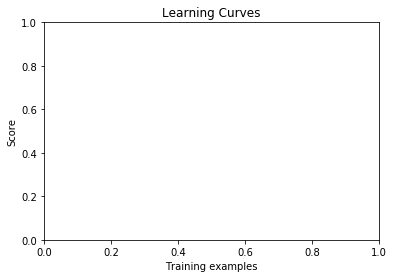

In [13]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [14]:
y_train.head()

0    4
1    4
2    4
5    4
8    4
Name: Target, dtype: int64

## Okay, now we use the most important features from the unconstricted RF

In [81]:
best_features = list(feature_importances.sort_values('importance', ascending=False)[:40]['feature'])
# best_features

In [82]:
full_pipeline = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(best_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [83]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'random_forest__max_depth': 25}
Wall time: 4.58 s


Cross Validation F1 Score = 0.3693 with std = 0.0144
Wall time: 8.64 s


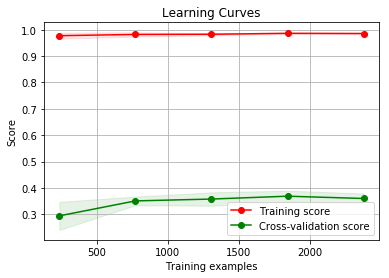

In [84]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [ ]:
### Okay, now we use the most important features from the unconstricted RF

In [18]:
BREAK 

NameError: name 'BREAK' is not defined

### Feature Selection
We will automate feature selection, but let's first visualize the relationship between number of features and cross-validation scroing for a RandomForestClassifier. It seems to be a toss-up after around 10 features

In [ ]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=1, max_depth=15), step=1, cv=kfold,
              scoring=f1_scorer)

transformers = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ])
X_transformed = transformers.fit_transform(X_train)
rfecv.fit(X_transformed, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# For now do without ('processing', LazyProcessing())
full_pipeline = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [ ]:
from scipy.stats import randint

In [ ]:
param_dist = dict(random_forest__max_depth=randint(4,24),
                 random_forest__min_samples_split=randint(2,16),
                 random_forest__min_samples_leaf=randint(1,6),
                random_forest__n_estimators=randint(10,50))

In [ ]:
%%time
random_search = RandomizedSearchCV(full_pipeline, param_dist, cv=kfold, scoring=f1_scorer, n_jobs=-1)
random_search.fit(X_train, y_train)

report(random_search.cv_results_)


In [ ]:
param_grid = dict(random_forest__max_depth=list(range(4,24,4)),
                 random_forest__min_samples_split=list(range(2,16,2)),
                 random_forest__min_samples_leaf=list(range(1,6)),
                  random_forest__n_estimators=list(range(10,51,10)))
print(param_grid)

In [ ]:
%%time
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report(grid.cv_results_)

In [ ]:
model = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('xgb', XGBClassifier(random_state=1, num_class = 4,
                                             n_estimators=1000, learning_rate=0.1))])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

## Find ideal n_estimators via grid_search

In [ ]:
param_grid = dict(xgb__n_estimators=[100,300,500,1000,1500,2000,5000],
                 xgb__learning_rate=[0.01, 0.05, 0.10])
print(param_grid)

In [ ]:
%%time
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report(grid.cv_results_)

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

In [ ]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [ ]:
results = pd.DataFrame({'n_estimators':grid.cv_results_['param_xgb__n_estimators'].tolist(), 'mean_test_score':grid.cv_results_['mean_test_score']}) 
             #columns = ['n_estimators', 'mean_train_score'])

In [ ]:
results = pd.DataFrame({'n_estimators':grid.cv_results_['param_xgb__n_estimators'].tolist(),
                        'learning_rate':grid.cv_results_['param_xgb__learning_rate'].tolist(), 
                        'mean_test_score':grid.cv_results_['mean_test_score']}) 
             #columns = ['n_estimators', 'mean_train_score'])

In [ ]:
sns.lineplot(x='n_estimators', y='mean_test_score', hue='learning_rate', data=results)

## TODO 
- see if setting early_stopping_rounds gives you the same n_estimators as grid_search (requires holding out some test data as per https://www.kaggle.com/dansbecker/xgboost) 

In [ ]:
model = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1,
                                                                max_depth=20))])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [ ]:
model = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1,
                                                                max_depth=20))])

In [ ]:
%%time
model.fit(X_train, y_train)
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [ ]:
%%time
DEPTHS = list(range(10,20))
param_grid = dict(random_forest__max_depth=DEPTHS)
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

In [ ]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

In [ ]:
%%time
cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(cv_score.mean())
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

# Learning Curve
*YIKES*, given we aren't getting more data, we need to avoid such bad overfitting

In [ ]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [ ]:
estimator = model.steps[-1][1]

# WARNING - need to fix for automated feature selection, as column names/orders are not preserved
# feature_importances = pd.DataFrame({'feature': test_features, 'importance': estimator.feature_importances_})
# feature_importances.sort_values('importance', ascending=False)

estimator.feature_importances_

# Submission

In [ ]:
# Save model for error analysis (other notebook)
joblib.dump(model, '../models/random_forest.pkl')

# model = joblib.load('../models/random_forest.pkl')

In [ ]:
y_pred = model.predict(X_test)
# plt.hist(y_pred)

In [ ]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)

In [ ]:
submission.to_csv('../submission.csv', index=None)

In [ ]:
submission.head()

## Error Analysis

In [ ]:
y_train_predict = cross_val_predict(model, X_train, y_train, cv = kfold)

In [ ]:
plot_confusion_matrix(y_train, y_train_predict, xticklabels = [1,2,3,4], yticklabels=[1,2,3,4])